In [14]:
import maboss
import ginsim
import pandas as pd 
import numpy as np


from identification_patients.get_patients_sens_res import get_patients

from create_generic_models.create_generic_patients_cfgs import create_generic_patients_cfgs_bnds
from pre_process_data.pre_process_genes import create_table_rna_seq_patients, process_genes

from create_person_models.tailor_cfgs_patients_gene import personalized_patients_genes_cfgs
from create_person_models.tailor_bnd_mutations import personalized_patients_mutations_bnds

from MaBoSS_simulation.MaBoSS_phenotype_distribution import compute_phenotypes_distribution, compute_mean_patients
from pre_process_data.identify_mutations_patients import identif_mutations_kras_egfr

# # from pre_process_profiles_table_data_lung import create_genes_patients

from stats.stats_proba import compute_mannwhitneyu_test_means
from results_MaBoSS_visualization.boxplot_phenotype import create_boxplot
from results_MaBoSS_visualization.create_phenotypes_patients_table import vizualise_table_phenotype_condition
from results_MaBoSS_visualization.patients_ids_phenotype_table import create_table_patients_phenotypes
from gene_enrichment.genes_signature import compute_genes_mean_signature


In [15]:
import os
print(os.getcwd())


/Users/romane/repos/icr/Attractor-Resistance


Step 0: Import data 

In [ ]:
# Import Data

annotations_models = pd.read_csv('data/model_list_20250407.csv')
mutations_data = pd.read_csv('data/mutations_all_20250318.csv')
drug_data = pd.read_csv('data/drug_sensitivity.csv')

montagud_data = (
    pd.read_csv('data/Montagud_inter_nodes_data.csv', header=1)
    .loc[:, ['Target node', 'Interaction type', 'Source']])
rna_seq_data = pd.read_csv('data/rnaseq_merged/rnaseq_merged_20250117.csv')


Step 1: Pre-process data- Montagud nodes, rna-seq (filtered with patients IDs and Montagud nodes)

In [ ]:
# Pre-process Montagud nodes

# Keep only the nodes of montagud not specific to Prostate 
montagud_nodes = list(set(montagud_data['Target node'].tolist() + montagud_data['Source'].tolist()))

print(type(montagud_nodes))

montagud_nodes = [node for node in montagud_nodes if node != '0/1']
montagud_nodes = [node.upper() for node in montagud_nodes if isinstance(node, str)]
montagud_nodes.append('KRAS')
to_remove = ['RAS', 'FUSED_EVENT', 'NKX3_1', 'SPOP', 'AR_ERG']

montagud_nodes = [node for node in montagud_nodes if node not in to_remove]
montagud_nodes = list(set(montagud_nodes))
print(montagud_nodes)

<class 'list'>
['MDM2', 'HSPS', 'BIRC5', 'TGFBR', 'RB1', 'COX4I2', 'CDH2', 'TCF', 'DNA_REPAIR', 'ETS1', 'PIP3', 'APAF1', 'ROS', 'BETA_CATENIN', 'DSH', 'P14ARF', 'GLI', 'FRS2', 'PHDS', 'CYTOC', 'TWIST1', 'INVASION', 'MED12', 'RAF', 'WNT', 'CYCLIND', 'ZBTB17', 'EEF2K', 'PKC', 'CASPASE9', 'E_CADHERIN', 'RHEB', 'CASPASE3', 'VEGF', 'FADD', 'IKK', 'LACTIC_ACID', 'ATM', 'MTORC2', 'DAXX', 'AMPK', 'TERT', 'HYPOXIA', 'P90RSK', 'YWHAZ', 'NUTRIENTS', 'FOXA1', 'P38', 'MAP3K1_3', 'CASPASE8', 'NCOA3', 'DNA_DAMAGE', 'EMT', 'TGFB', 'TAK1', 'MEK1_2', 'VHL', 'PTEN', 'PTCH1', 'SNAIL', 'E2F1', 'EGFR', 'ERK', 'JUN', 'EP300', 'ACIDOSIS', 'TSC1_2', 'GSK3', 'FGF', 'BMP2', 'RUNX2', 'BAK', 'NCOR2', 'AKT', 'HIF1', 'MXI1', 'LDHA', 'BCL_XL', 'PROLIFERATION', 'P15', 'GLUT1', 'AXIN1', 'FGFR3', 'ERG', 'CYCLINB', 'BRCA1', 'TNFALPHA', 'ATR', 'MIGRATION', 'EZH2', 'BRCA2', 'NCOR1', 'NF1', 'KRAS', 'PI3K', 'IDH1', 'EGF', 'METASTASIS', 'PDK1', 'ANDROGEN', 'CFLAR', 'GSH', 'BCL2', 'MYC_MAX', 'APOPTOSIS', 'P53', 'P70S6KAB', 'FO

In [ ]:
# chose folder where we want all the personalized boolean models and associated results saved 
folder_pers_models='models/personalized_boolean_large_groups'
folder_result = 'results'
# Output directories
output_dir_resistant = f'{folder_pers_models}/resistant_patient/generic_models'
output_dir_sec_resistant = f'{folder_pers_models}/resistant_patient/personalized_boolean_modified'
output_dir_sensitive = f'{folder_pers_models}/sensitive_patient/generic_models'
output_dir_sec_sensitive = f'{folder_pers_models}/sensitive_patient/personalized_boolean_modified'
bnd_dir_res = f'{folder_pers_models}/resistant_patient/personalized_boolean_modified/models_gene_expression'
bnd_dir_sens = f'{folder_pers_models}/sensitive_patient/personalized_boolean_modified/models_gene_expression'



In [ ]:
tissue_remove = 'Haematopoietic and Lymphoid'
tissue_interest = 'Lung'

Step 1: Check what drug is the best to keep (the one with most resistant and sensitive)

In [26]:
# results = {}
# drug_interests = drug_data['DRUG_NAME'].unique().tolist()
# #print(drug_interests)
# for drug_interest in drug_interests:
#     results[drug_interest] = get_patients(100, drug_data, annotations_models, tissue_interest, drug_interest)

# drug_interest: {
#     "name": drug_interest,
#     "<-1.5": float((df['Z_SCORE'] < -1.5).sum()),
#     ">1.5": float((df['Z_SCORE'] > 1.5).sum()),
#     "mean": float(df['Z_SCORE'].mean()),
#     "std": float(df['Z_SCORE'].std()),
#     "abs_zscore": float(df['Z_SCORE'].abs().mean()),
# }

# list_results = results.values()
# pd_results = pd.DataFrame(list_results)
# pd_results.to_csv(f'{folder}/drug_analysis.csv")

Step 2: Select cancer and drug of interest (tissue_interest, drug_interest)
Get the 100 most sensitive patient
Pre-process data


In [ ]:
# Get patients IDs

# top_resistant_ids, top_sensitive_ids= get_patients(drug_data, annotations_models, drug_interest, tissue_interest)
drug_interest = 'AZD8931' #'Avagacestat' AZD8931
tissue_remove = 'Haematopoietic and Lymphoid'
top_resistant_ids, top_sensitive_ids, drug_tissue_data= get_patients(100, drug_data, annotations_models, drug_interest)
patients_ids = top_sensitive_ids + top_resistant_ids



In [ ]:
# Pre-process RNA seq data (keep only montagud_nodes and patients ids) and create table for high and low expression
rna_seq_data_filtered = process_genes(patients_ids, montagud_nodes, rna_seq_data)
table_rna_seq_patients = create_table_rna_seq_patients(rna_seq_data)


/Users/romane/repos/icr/Attractor-Resistance/pre_process_data/pre_process_genes.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_seq_data.rename(columns={'gene_symbol': 'gene_name'}, inplace=True)


In [ ]:
print(rna_seq_data_filtered.head())
print(table_rna_seq_patients.head())

Step 3: Create generic boolean networks with the sensitive and resistant ID names


In [7]:
folder_generic_models_cfg = 'models/generic_models/Adeno_lung_Cancer.cfg'
folder_generic_models_bnd = 'models/generic_models/Adeno_lung_Cancer.bnd'
create_generic_patients_cfgs_bnds(folder_generic_models_cfg, folder_generic_models_bnd, folder_pers_models, top_resistant_ids, top_sensitive_ids, drug_interest)


All .cfg and .bnd files created for sensitive and resistant patients.


Step 4: Personalize the cfg files with genes/ proteins


In [15]:
personalized_patients_genes_cfgs(rna_seq_data, montagud_data, output_dir_resistant, output_dir_sec_resistant, patients_ids, rna_seq_data_filtered, drug_interest)
personalized_patients_genes_cfgs(rna_seq_data, montagud_data, output_dir_sensitive, output_dir_sec_sensitive, patients_ids, rna_seq_data_filtered, drug_interest)

SIDM00948_AZD8931.cfg
SIDM00446_AZD8931.bnd
Modified and saved: models/personalized_boolean_large_groups/resistant_patient/personalized_boolean_modified/models_gene_expression/SIDM00446_AZD8931.bnd
SIDM01057_AZD8931.cfg
SIDM00524_AZD8931.bnd
Modified and saved: models/personalized_boolean_large_groups/resistant_patient/personalized_boolean_modified/models_gene_expression/SIDM00524_AZD8931.bnd
SIDM00422_AZD8931.cfg
SIDM01079_AZD8931.cfg
Modified and saved: models/personalized_boolean_large_groups/resistant_patient/personalized_boolean_modified/models_gene_expression/SIDM01079_AZD8931.cfg
SIDM00495_AZD8931.bnd
SIDM00621_AZD8931.bnd
Modified and saved: models/personalized_boolean_large_groups/resistant_patient/personalized_boolean_modified/models_gene_expression/SIDM00621_AZD8931.bnd
SIDM01121_AZD8931.bnd
Modified and saved: models/personalized_boolean_large_groups/resistant_patient/personalized_boolean_modified/models_gene_expression/SIDM01121_AZD8931.bnd
SIDM01177_AZD8931.cfg
Modified a

TO DO: change the path for the results 

Step 5: Identification of which patients id have KRAS or EGFR mutation
personalize the bnd files with the mutations common to Lung (KRAS/ EGFR):

In [16]:
personalized_patients_mutations_bnds(mutations_data,patients_ids,bnd_dir_res, drug_interest)
personalized_patients_mutations_bnds(mutations_data,patients_ids,bnd_dir_sens, drug_interest)

SIDM00723
kras
<re.Match object; span=(13717, 13841), match='Node KRAS {\n  logic = (EGFR | TGFBR | FRS2 | FGF>

KRAS node before replacement: Node KRAS {
  logic = (EGFR | TGFBR | FRS2 | FGFR3);
  rate_up = @logic ? $u_KRAS : 0;
  rate_down = @logic ? 0 : $d_KRAS;
}
SIDM00723: KRAS mutation — node modified
Modified content for SIDM00723_AZD8931.bnd:
Node Acidosis {
  logic = (Acidosis);
  rate_up = @logic ? $u_Acidosis : 0;
  rate_down = @logic ? 0 : $d_Acidosis;
}

Node AKT {
  logic = ((HSPs | (PDK1 & PIP3) | PIP3 | (SHH & PIP3)) & !PTCH1);
  rate_up = @logic ? $u_AKT : 0;
  rate_down = @logic ? 0 : $d_AKT;
}

Node AMPK {
  logic = (ATR | HIF1 | AMP_ATP | ATM) & !FGFR3;
  rate_up = @logic ? $u_AMPK : 0;
  rate_down = @logic ? 0 : $d_AMPK;
}

Node AMP_ATP {
  logic = (!Nutrients);
  rate_up = @logic ? $u_AMP_ATP : 0;
  rate_down = @logic ? 0 : $d_AMP_ATP;
}

Node Androgen {
  logic = (Androgen);
  rate_up = @logic ? $u_Androgen : 0;
  rate_down = @logic ? 0 : $d_Androgen;
}

Node APA

Step 6: compute the phenotype distribution 

In [24]:
dic_patient_resistant =f'{folder_pers_models}/resistant_patient/personalized_boolean_modified/models_gene_expression'
dic_patient_sensitive =f'{folder_pers_models}/sensitive_patient/personalized_boolean_modified/models_gene_expression'
inputs_list = ['EGF', 'FGF', 'TGFb', 'Nutrients', 'Hypoxia', 'Acidosis', 'Androgen', 'TNFalpha', 'Carcinogen']


patient_res_data_dict = compute_phenotypes_distribution(folder_result, dic_patient_resistant, inputs_list, 'resistant', drug_interest)
patient_sens_data_dict = compute_phenotypes_distribution(folder_result, dic_patient_sensitive, inputs_list, 'sensitive', drug_interest)
patients_res_df_mean, patients_res_df_std, stats_results_data_res_df = compute_mean_patients(patient_res_data_dict)
patients_sens_df_mean, patients_sens_df_std, stats_results_data_sens_df = compute_mean_patients(patient_sens_data_dict)



patients_res_df_mean.to_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_df_mean_{drug_interest}.csv', index=True)
patients_res_df_std.to_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_df_std_{drug_interest}.csv', index=True)
stats_results_data_res_df.to_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_values_stats_{drug_interest}.csv', index=True)
stats_results_data_sens_df.to_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_values_stats_{drug_interest}.csv', index=True)
patients_sens_df_mean.to_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_df_mean_{drug_interest}.csv', index=True)
patients_sens_df_std.to_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_df_std_{drug_interest}.csv', index=True)




--- Results for patient: SIDM01079_AZD8931 ---
                  <nil>  Apoptosis  Proliferation  Metastasis
EGF_ON         0.905736   0.000000       0.000833    0.075630
FGF_ON         0.957386   0.033914       0.006000    0.000800
TGFb_ON        0.000200   0.999800       0.000000    0.000000
Nutrients_ON   1.000000   0.000000       0.000000    0.000000
Hypoxia_ON     0.996894   0.000000       0.000000    0.003106
Acidosis_ON    1.000000   0.000000       0.000000    0.000000
Androgen_ON    0.905536   0.000000       0.000833    0.075430
TNFalpha_ON    1.000000   0.000000       0.000000    0.000000
Carcinogen_ON  0.974407   0.018086       0.005307    0.000600

--- Results for patient: SIDM01177_AZD8931 ---
                  <nil>  Apoptosis  Proliferation  Metastasis
EGF_ON         0.921200   0.000000       0.064000      0.0000
FGF_ON         0.993800   0.000000       0.006200      0.0000
TGFb_ON        0.719000   0.113400       0.000200      0.1674
Nutrients_ON   1.000000   0.000000  

Step 7: Compute stats test between two mean datasets

In [8]:
patient_res_stats_values = pd.read_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_values_stats_{drug_interest}.csv')
patient_sens_stats_values = pd.read_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_values_stats_{drug_interest}.csv')
compute_mannwhitneyu_test_means(folder_result,patient_res_stats_values, patient_sens_stats_values, drug_interest)

Step 8: Vizualise the boxplot of phenotype distribution output

the df_combined is:
       Phenotype      Condition      Group  Expression  \
0          <nil>         EGF_ON  Resistant    0.905736   
1          <nil>         EGF_ON  Resistant    0.921200   
2          <nil>         EGF_ON  Resistant    0.870400   
3          <nil>         EGF_ON  Resistant    0.816400   
4          <nil>         EGF_ON  Resistant    0.964931   
...          ...            ...        ...         ...   
7078  Metastasis  Carcinogen_ON  Sensitive    0.000693   
7079  Metastasis  Carcinogen_ON  Sensitive    0.004687   
7080  Metastasis  Carcinogen_ON  Sensitive    0.000000   
7081  Metastasis  Carcinogen_ON  Sensitive    0.001264   
7082  Metastasis  Carcinogen_ON  Sensitive    0.000837   

                Condition_Group  
0            EGF_ON (Resistant)  
1            EGF_ON (Resistant)  
2            EGF_ON (Resistant)  
3            EGF_ON (Resistant)  
4            EGF_ON (Resistant)  
...                         ...  
7078  Carcinogen_ON (Sensitive)  
7079  Carci

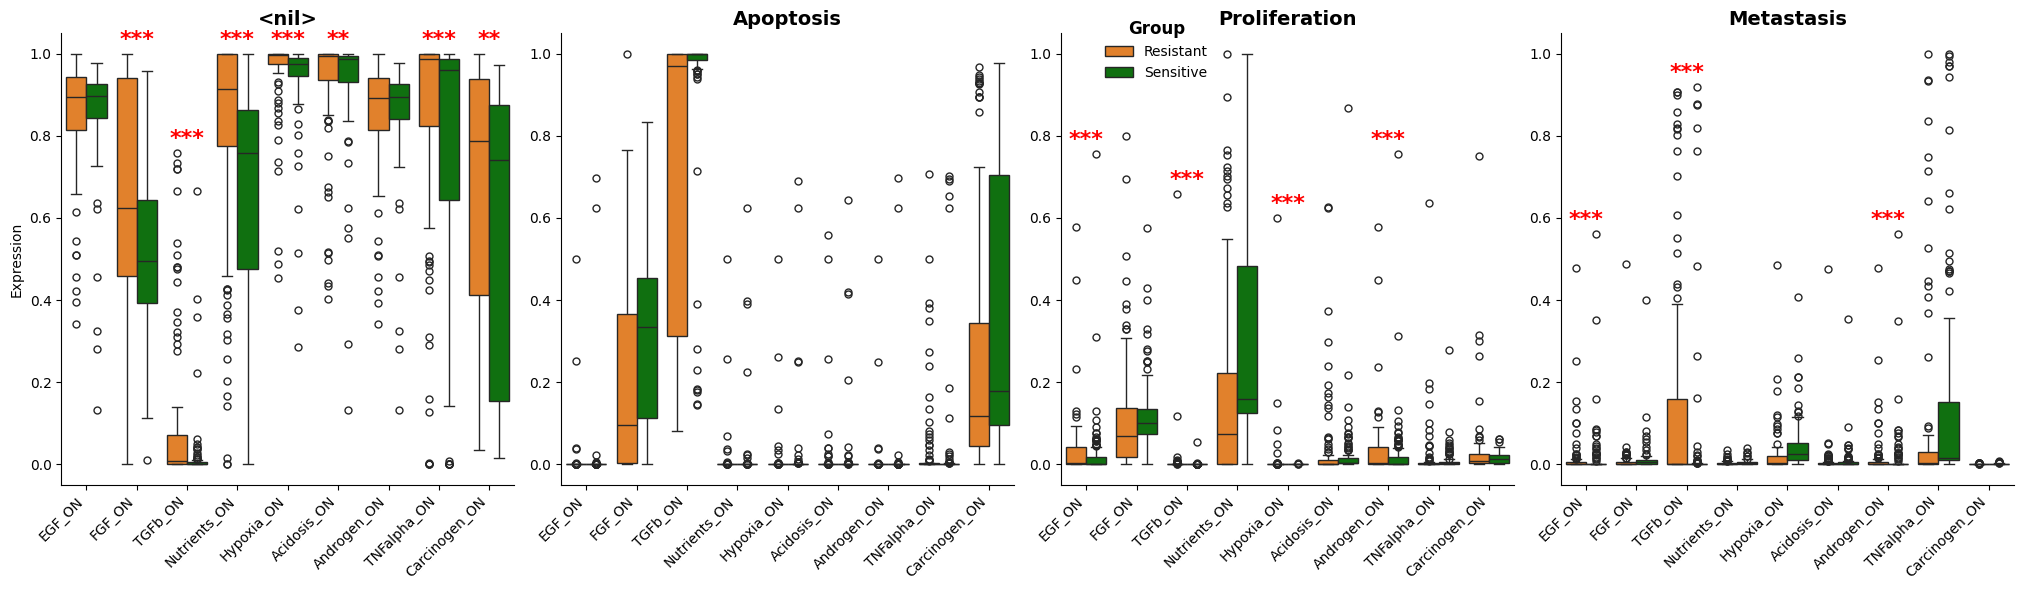

In [9]:
patient_res_values = pd.read_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_values_stats_{drug_interest}.csv')
patient_sens_values = pd.read_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_values_stats_{drug_interest}.csv')
data_greater_side = pd.read_csv(f'{folder_result}/sensitive_resistant_results/p_values_df_mannwhitneyu_greater_sign_{drug_interest}.csv')
create_boxplot(folder_result, patient_res_values, patient_sens_values, data_greater_side)

Step 9: create table of patients with conditions- phenotype

In [10]:
dir_res_data = f'{folder_result}/resistant_results/only_gene_expression/single_input_on/phenotype_distribution_patients'
dir_sens_data = f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/phenotype_distribution_patients'
patients_phenot_table = create_table_patients_phenotypes(folder_result, dir_res_data, dir_sens_data)

Loaded data for SIDM00700_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00454_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM01181_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00331_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM01104_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00826_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00648_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00410_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00859_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00492_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00230_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00194_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00511_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00340_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00381_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM01210_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM01079_AZD8931_phenot

Step 10: Create heatmap figure 

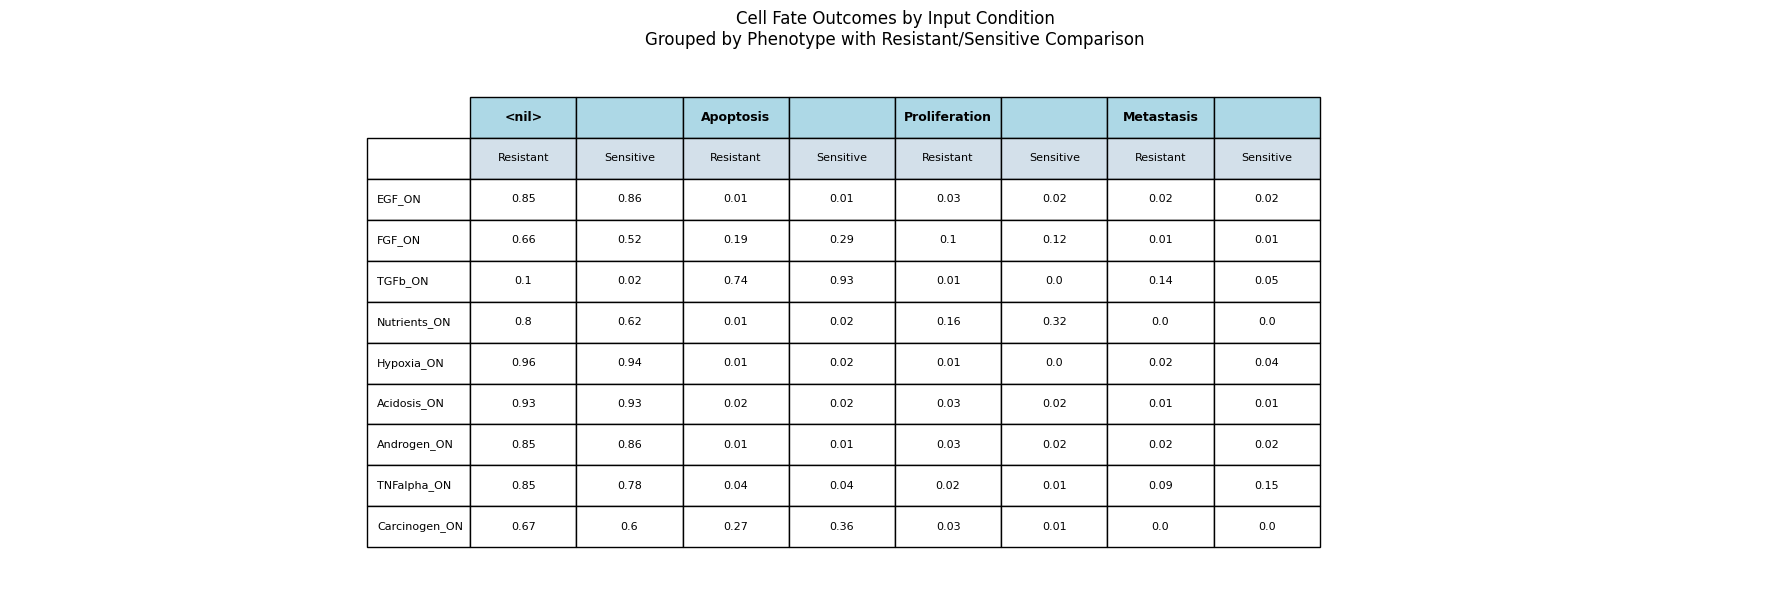

In [11]:
patient_resistant_mean = pd.read_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_df_mean_{drug_interest}.csv')
patient_sensitive_mean = pd.read_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_df_mean_{drug_interest}.csv')
vizualise_table_phenotype_condition(folder_result, patient_resistant_mean, patient_sensitive_mean)

Step 11: Identify genes differently expressed in the patients with high 

In [ ]:
patients_phenot_table = pd.read_csv(f'{folder_result}/sensitive_resistant_results/patients_phenot_table.csv')
genes_stats_results_metast_TGFb = compute_genes_mean_signature(rna_seq_data_filtered, folder_result, montagud_nodes, 'Metastasis', 'TGFb', patients_phenot_table, top_resistant_ids, top_sensitive_ids)
genes_stats_results_prolif_egf = compute_genes_mean_signature(rna_seq_data_filtered, folder_result, montagud_nodes, 'Proliferation', 'EGF', patients_phenot_table, top_resistant_ids, top_sensitive_ids)

/Users/romane/repos/icr/Attractor-Resistance/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


KeyboardInterrupt: 

Step 11: check there is not correlation between phenotype distribution and cancer type 


In [ ]:
patients_phenot_table['SANGER_MODEL_ID'] = patients_phenot_table['Unnamed: 0'].str.split('_').str[0]
conditions = [
    patients_phenot_table['SANGER_MODEL_ID'].isin(top_resistant_ids),
    patients_phenot_table['SANGER_MODEL_ID'].isin(top_sensitive_ids)
    ]
choices = ['Resistant', 'Sensitive']
patients_phenot_table.loc[:,'Drug status'] = np.select(conditions, choices, default = '')



ids_tissue_data = drug_tissue_data[['SANGER_MODEL_ID', 'tissue']]
ids_tissue_data = ids_tissue_data.drop_duplicates(subset='SANGER_MODEL_ID')


# merge tissues and model id 
patients_phenot_table = pd.merge(patients_phenot_table, ids_tissue_data, on = 'SANGER_MODEL_ID')
print(patients_phenot_table)



# look the number of each cancer for the condition-phenotype of interest
condition = 'TGFb'
phenotype = 'Metastasis'


# resistant group changes according to what is the condition and the phenotype
# group_proliferation_resistant: group with high phenotype 

group_phenotype_resistant = patients_phenot_table[
    (patients_phenot_table['Drug status'] == 'Resistant') & 
    (patients_phenot_table[f'{condition}_ON_{phenotype}'] >= 0.1)
]

# print(group_phenotype_resistant['tissue'].value_counts()) # EGF- proliferation: 4 lung, 1 breast, 1 haematopoetic
#                                                           # TGFb- Metastasis: 21 haemato, 2 skin, 2 breast, 1 lung, 1 large intestine, 1 endom, 1 liver
